# Parsing PDFs Homework

With the power of pdfminer, pytesseract, Camelot, and Tika, let's analyze some documents!

> If at any point you think, **"I'm close enough, I'd just edit the rest of it in Excel"**: that's fine! Just make a note of it.

## A trick to use again and again

### Approach 1

Before we get started: when you want to take the first row of your data and set it as the header, use this trick.

In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame([
    [ 'fruit name', 'likes' ],
    [ 'apple', 15 ],
    [ 'carrot', 3 ],
    [ 'sweet potato', 45 ],
    [ 'peach', 12 ],
])
df

,0,1
0,fruit name,likes
1,apple,15
2,carrot,3
3,sweet potato,45
4,peach,12


In [7]:
# Set the first column as the columns
df.columns = df.loc[0]

# Drop the first row
df = df.drop(0)

df

,fruit name,likes
1,apple,15
2,carrot,3
3,sweet potato,45
4,peach,12


🚀 Done!

### Approach 2

Another alternative is to use `.rename` on your columns and just filter out the columns you aren't interested in. This can be useful if the column name shows up multiple times in your data for some reason or another.

In [5]:
# Starting with the same-ish data...
df = pd.DataFrame([
    [ 'fruit name', 'likes' ],
    [ 'apple', 15 ],
    [ 'carrot', 3 ],
    [ 'fruit name', 'likes' ],
    [ 'sweet potato', 45 ],
    [ 'peach', 12 ],
])
df

,0,1
0,fruit name,likes
1,apple,15
2,carrot,3
3,fruit name,likes
4,sweet potato,45
5,peach,12


In [4]:
df = df.rename(columns={
    0: 'fruit name',
    1: 'likes'
})
df = df[df['fruit name'] != 'fruit name']
df

,fruit name,likes
1,apple,15
2,carrot,3
3,sweet potato,45
4,peach,12


🚀 Done!

### Useful tips about coordinates

If you want to grab only a section of the page [Kull](https://jsoma.github.io/kull/#/) might be helpful in finding the coordinates.

> **Alternatively** run `%matplotlib notebook` in a cell. Afterwards, every time you use something like `camelot.plot(tables[0]).show()` it will get you nice zoomable, hoverable versions that include `x` and `y` coordinates as you move your mouse.

Coordinates are given as `"left_x,top_y,right_x,bottom_y"` with `(0,0)` being in the bottom left-hand corner.

Note that all coordinates are strings, for some reason. It won't be `[1, 2, 3, 4]` it will be `['1,2,3,4']`

# Camelot questions

The largest part of this assignment is **mostly Camelot work**. As tabular data is usually the most typical data you'll be working with, it's what I'm giving you!

It will probably be helpful to read through [Camelot's advanced usage tips](https://camelot-py.readthedocs.io/en/master/user/advanced.html), along with the notebook I posted in the homework assignment.

## Prison Inmates

Working from [InmateList.pdf](InmateList.pdf), save a CSV file that includes every inmate.

* Make sure your rows are *all data*, and you don't have any people named "Inmate Name."


In [70]:
import camelot
import pandas as pd

%matplotlib notebook

# Read every page of PDF in camelot
tables = camelot.read_pdf('InmateList.pdf', flavor="stream", pages="all")

<IPython.core.display.Javascript object>


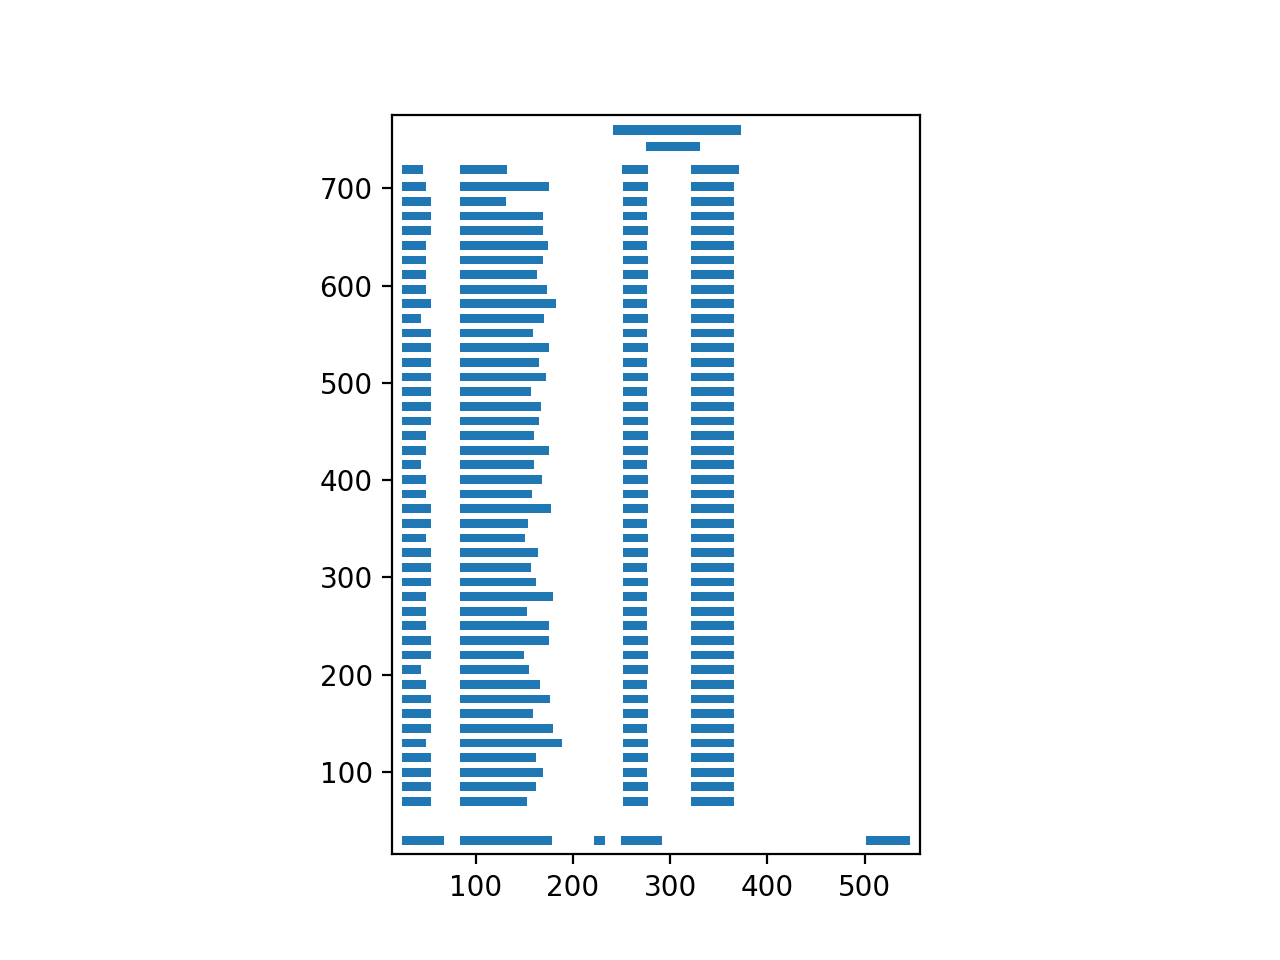

In [71]:
# Get coordinates (top left x, top left y, bottom right x, bottom right y)
camelot.plot(tables[0]).show()

In [74]:
# Read all pages of PDF into camelot with x, y coordinates in table_areas
tables = camelot.read_pdf('InmateList.pdf', pages= 'all', flavor= 'stream', table_areas=['18, 714, 373, 60'])

# Convert each page into a dataframe. Returns a list of dataframes, one per page
dfs = [table.df for table in tables]

# Concatenate all dataframes from dfs into one df
df = pd.concat(dfs, ignore_index=True)

# Rename the columns
df = df.rename(columns={
    0: 'icn',
    1: 'inmate_name',
    2: 'facility',
    3: 'booking date'
})

df.head()

,icn,inmate_name,facility,booking date
0,70693,"ABDALLAH, MICHAEL",ECHC,04/30/2021
1,152645,"ABDI, ABDI",ECCF,06/20/2021
2,144666,"ABDULLAH, DHAFIR",ECCF,06/17/2021
3,156374,"ACEVEDO, CARLOS",ECHC,06/06/2021
4,57243,"ACKER, RAYMOND P",ECCF,11/02/2020


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 684 entries, 0 to 683
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   icn           684 non-null    object
 1   inmate_name   684 non-null    object
 2   facility      684 non-null    object
 3   booking date  684 non-null    object
dtypes: object(4)
memory usage: 21.5+ KB


In [77]:
df[df.inmate_name == 'Inmate Name']

,icn,inmate_name,facility,booking date


In [78]:
df.to_csv('inmates.csv', index=False)

## WHO resolutions

Using [A74_R13-en.pdf](A74_R13-en.pdf), what ten member countries are given the highest assessments?

* You might need to have two separate queries, and combine the results: that last page is pretty awful!
* Always rename your columns
* Double-check that your sorting looks right......
* You can still get the answer even without perfectly clean data

In [80]:
tables = camelot.read_pdf('A74_R13-en.pdf', flavor="stream", pages="all")

<IPython.core.display.Javascript object>


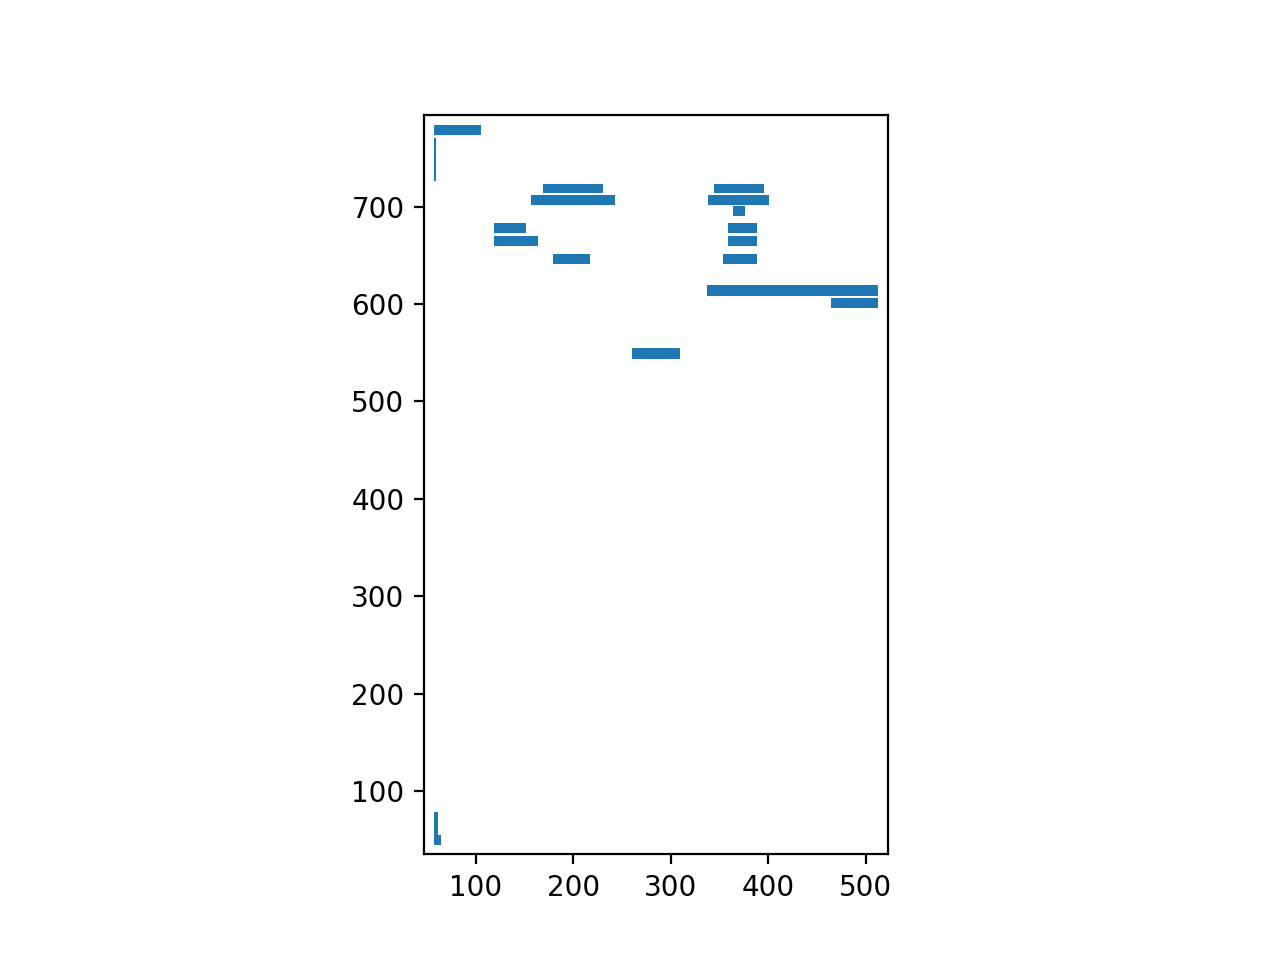

In [83]:
camelot.plot(tables[5]).show()

In [84]:
# Extract the row 3 onwards from first five pages
part_1 = [table.df.iloc[3: , :] for table in tables[0:5]]

# Concatenate first five pages
part_1 = pd.concat(part_1, ignore_index=True)

# Rename columns
part_1 = part_1.rename(columns = 
                       {0: 'members_and_associate_members',
                        1: 'who_scale_2223'})

In [85]:
# Page 6 is a mess
# Extract rows 4 and 5, and columns 1-3
# Then limit to columns 1 and 3
part_2 = tables[5].df.iloc[4:6 , 1:4][[1, 3]]

# Rename columns to watch dfs
part_2 = part_2.rename(columns = {1: 'members_and_associate_members',
                          3: 'who_scale_2223'})

In [86]:
# Concatenate dfs and p6
df = pd.concat([part_1, part_2])

df.who_scale_2223 = pd.to_numeric(df.who_scale_2223, errors = 'coerce')

Answering the question: **what ten member countries are given the highest assessments?**

In [87]:
df.sort_values('who_scale_2223', ascending=False).head(10)

,members_and_associate_members,who_scale_2223
193,United States of America,22.0000
35,China,12.0058
88,Japan,8.5645
68,Germany,6.0904
191,Northern Ireland,4.5673
64,France,4.4273
86,Italy,3.3072
23,Brazil,2.9482
31,Canada,2.7342
148,Russian Federation,2.4052


## The Avengers

Using [THE_AVENGERS.pdf](THE_AVENGERS.pdf), approximately how many lines does Captain America have as compared to Thor and Iron Man?

* Character names only: we're only counting `IRON MAN` as Iron Man, not `TONY`.
* Your new best friend might be `\n`
* Look up `.count` for strings

N.B. I originally attempted this question with Camelot, but found PDF Miner much more straightforward!

In [97]:
from pdfminer.high_level import extract_text

text = extract_text('THE_AVENGERS.pdf')

avengers = pd.Series(text)

captain_america_count = avengers.str.count(r'\nCAPTAIN\sAMERICA?(\s\(V.O\))?\n').sum()

iron_man_count = avengers.str.count(r'\nIRON\sMAN?(\s\(V.O\))?\n').sum()

thor_count = avengers.str.count(r'\nTHOR?(\s\(V.O\))?\n').sum()

print(f'Captain America has {captain_america_count} lines including voiceovers.')
print(f'Thor has {thor_count} lines including voiceovers.')
print(f'Iron Man has {iron_man_count} lines including voiceovers.')

Captain America has 36 lines including voiceovers.
Thor has 47 lines including voiceovers.
Iron Man has 19 lines including voiceovers.


## COVID data

Using [covidweekly2721.pdf](covidweekly2721.pdf), what's the total number of tests performed in Minnesota? Use the Laboratory Test Rates by County of Residence chart.

* You COULD pull both tables separately OR you could pull them both at once and split them in pandas.
* Remember you can do things like `df[['name','age']]` to ask for multiple columns

<IPython.core.display.Javascript object>


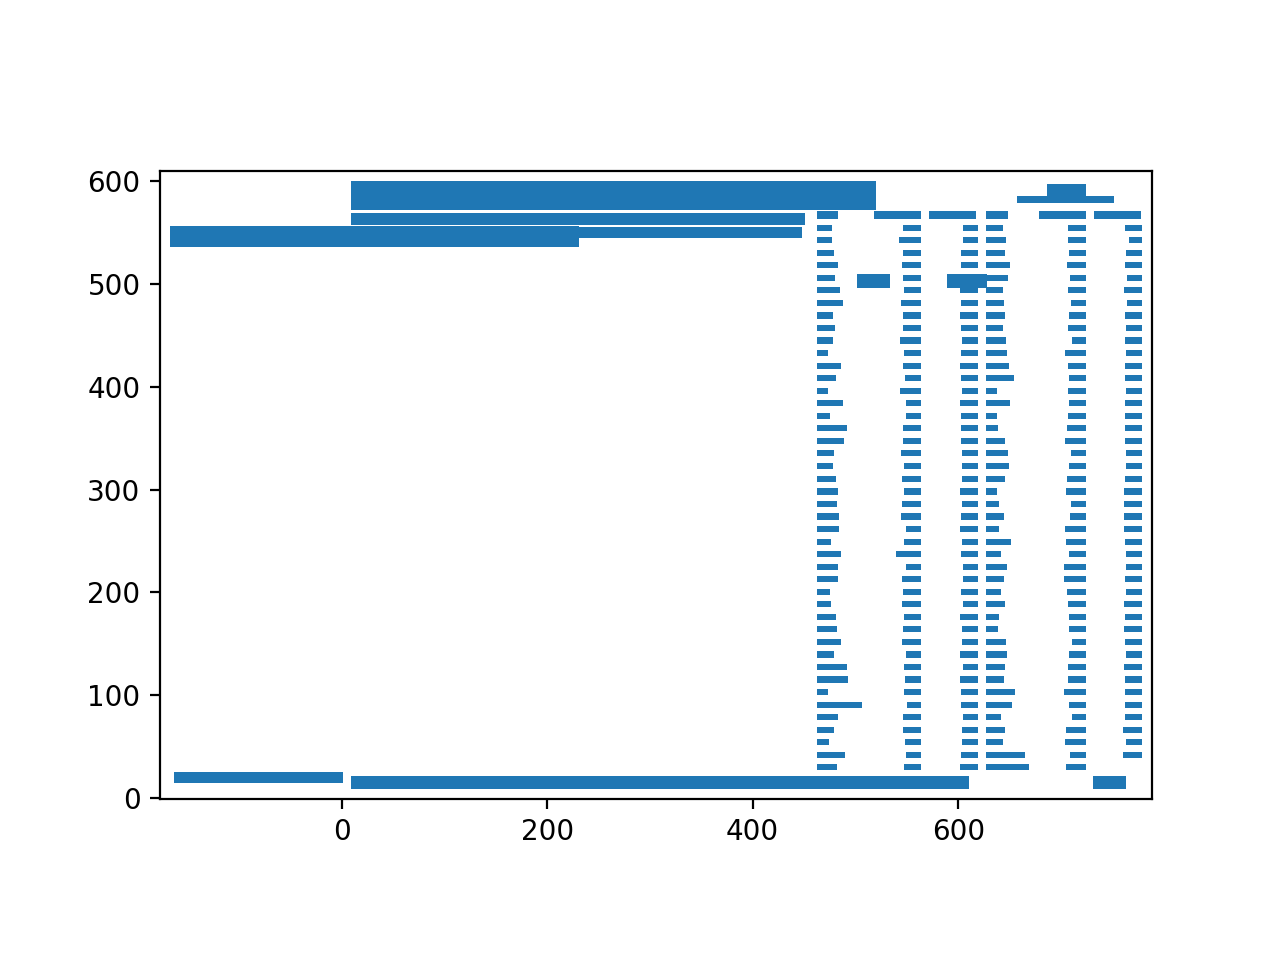

In [98]:
tables = camelot.read_pdf('covidweekly2721.pdf', flavor="stream", pages="6")

camelot.plot(tables[0]).show()

In [99]:
table_coords = '459.4, 576.2, 785, 24'

tables = camelot.read_pdf('covidweekly2721.pdf', pages= '6', flavor= 'stream', table_areas=[table_coords])

In [103]:
part_1 = tables[0].df[[0, 1, 2]]

part_1.columns = part_1.loc[0]

part_1 = part_1.drop(0)

# Drop the empty row
part_1 = part_1.drop(6)

# Manually fill in a missing value
part_1.iloc[4, 2] = '19,574'

part_1.head()

,County,Number of Tests,Cumulative Rate
1,Aitkin,"19,204","12,128"
2,Anoka,"545,958","15,714"
3,Becker,"59,238","17,540"
4,Beltrami,"60,345","13,085"
5,Benton,"77,865","19,574"


In [107]:
part_2 = tables[0].df[[3, 4, 5]]

part_2.columns = part_2.loc[0]

part_2 = part_2.drop(0)

# Drop the empty row
part_2 = part_2.drop(6)

part_2.head()

,County,Number of Tests,Cumulative Rate
1,Martin,"39,876","19,974"
2,McLeod,"61,300","17,111"
3,Meeker,"37,736","16,351"
4,Mille Lacs,"44,688","17,369"
5,Morrison,"59,179","17,961"


In [108]:
df = pd.concat([part_1, part_2], ignore_index=True)

df['Number of Tests'] = df['Number of Tests'].str.replace(',', '')

total_tests = df['Number of Tests'].astype('int').sum()

print(f'The total number of tests performed in Minnesota is {total_tests:,}')

The total number of tests performed in Minnesota is 10,249,823


## Theme Parks

Using [2019-Theme-Index-web-1.pdf](2019-Theme-Index-web-1.pdf), save a CSV of the top 10 theme park groups worldwide.

* You can clean the results or you can restrict the area the table is pulled from, up to you

<IPython.core.display.Javascript object>


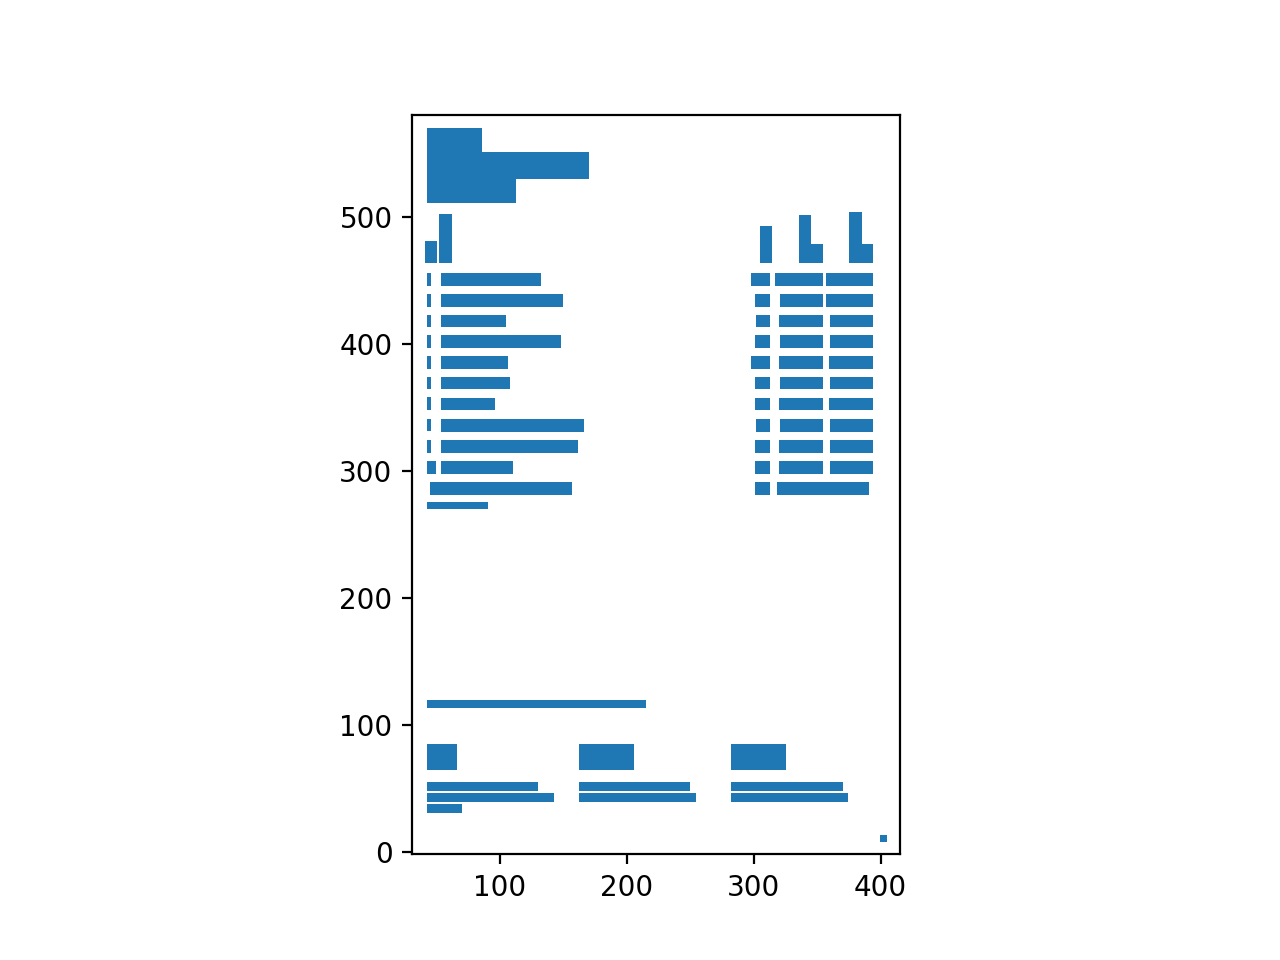

In [111]:
tables = camelot.read_pdf('2019-Theme-Index-web-1.pdf', flavor="stream", pages="11")

camelot.plot(tables[0]).show()

In [112]:
table_coords = '37.7, 460.6, 400.1, 295.6'

tables = camelot.read_pdf('2019-Theme-Index-web-1.pdf', pages= '11', flavor= 'stream', table_areas=[table_coords])

In [113]:
theme_parks = tables[0].df
theme_parks

,0,1,2,3,4
0,1,WALT DISNEY ATTRACTIONS,-0.8%,"155,991,000","157,311,000"
1,2,MERLIN ENTERTAINMENTS GROUP,0.9%,"67,000,000","66,400,000*"
2,3,OCT PARKS CHINA,9.4%,"53,970,000","49,350,000"
3,4,UNIVERSAL PARKS AND RESORTS,2.3%,"51,243,000","50,068,000"
4,5,FANTAWILD GROUP,19.8%,"50,393,000","42,074,000"
5,6,CHIMELONG GROUP,8.9%,"37,018,000","34,007,000"
6,7,SIX FLAGS INC.,2.5%,"32,811,000","32,024,000"
7,8,CEDAR FAIR ENTERTAINMENT COMPANY,7.8%,"27,938,000","25,912,000"
8,9,SEAWORLD PARKS & ENTERTAINMENT,0.2%,"22,624,000","22,582,000"
9,10,PARQUES REUNIDOS,6.2%,"22,195,000","20,900,000"


In [114]:
theme_parks = theme_parks.rename(columns = {
    0: 'rank',
    1: 'group_name',
    2: 'pc_change',
    3: 'attendance_2019',
    4: 'attendance_2018'
})

theme_parks.attendance_2019 = theme_parks.attendance_2019.str.replace(',', '').astype('int')
theme_parks.attendance_2018 = theme_parks.attendance_2018.str.replace('\*|\,', '', regex=True).astype('int')

theme_parks['pc_change'] = ((theme_parks.attendance_2019 - theme_parks.attendance_2018) / theme_parks.attendance_2018) * 100

theme_parks

,rank,group_name,pc_change,attendance_2019,attendance_2018
0,1,WALT DISNEY ATTRACTIONS,-0.839102,155991000,157311000
1,2,MERLIN ENTERTAINMENTS GROUP,0.903614,67000000,66400000
2,3,OCT PARKS CHINA,9.361702,53970000,49350000
3,4,UNIVERSAL PARKS AND RESORTS,2.346808,51243000,50068000
4,5,FANTAWILD GROUP,19.772306,50393000,42074000
5,6,CHIMELONG GROUP,8.854059,37018000,34007000
6,7,SIX FLAGS INC.,2.457532,32811000,32024000
7,8,CEDAR FAIR ENTERTAINMENT COMPANY,7.818771,27938000,25912000
8,9,SEAWORLD PARKS & ENTERTAINMENT,0.185989,22624000,22582000
9,10,PARQUES REUNIDOS,6.196172,22195000,20900000


In [115]:
theme_parks.to_csv('theme_parks.csv', index=False)

## Hunting licenses

Using [US_Fish_and_Wildlife_Service_2021.pdf](US_Fish_and_Wildlife_Service_2021.pdf) and [a CSV of state populations](http://goodcsv.com/geography/us-states-territories/), find the states with the highest per-capita hunting license holders.

In [117]:
tables = camelot.read_pdf('US_Fish_and_Wildlife_Service_2021.pdf', flavor="stream")

df = tables[0].df

df = df.copy().loc[5:60, 0:1]

df = df.rename(columns = {0: 'state',
                          1: 'license_holders'})

df.license_holders = df.license_holders.replace('\,', '', regex=True).astype('int')

df.head()

,state,license_holders
5,AK,93559
6,AL,452400
7,AR,343300
8,AS,0
9,AZ,302383


In [118]:
!wget 'http://goodcsv.com/wp-content/uploads/2020/08/us-states-territories.csv'

--2022-07-17 11:33:36--  http://goodcsv.com/wp-content/uploads/2020/08/us-states-territories.csv
Resolving goodcsv.com (goodcsv.com)... 64.111.124.200
Connecting to goodcsv.com (goodcsv.com)|64.111.124.200|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3478 (3.4K) [text/csv]
Saving to: ‘us-states-territories.csv.1’

us-states-territori 100%[===================>]   3.40K  --.-KB/s    in 0.003s  

2022-07-17 11:33:36 (1.27 MB/s) - ‘us-states-territories.csv.1’ saved [3478/3478]



In [152]:
states = pd.read_csv('us-states-territories.csv', encoding = 'unicode_escape')

states = states.rename(columns = {'Abbreviation': 'state',
                                  'Population (2019)': 'population'})

states = states[['state', 'population']]

states.state = states.state.str.replace(" ", "")

states = states[(states.state.isin(df.state)) & states.population.notnull()]

states.population = states.population.str.replace(',', '').astype('int')

states.head()

,state,population
0,AL,4903185
1,AK,731545
2,AZ,7278717
3,AR,3017804
4,CA,39512223


In [155]:
merged = df.merge(states, on='state', how='left')

merged['licenses_per_capita'] = merged.license_holders / merged.population

merged.sort_values('licenses_per_capita', ascending=False).head(10)

,state,license_holders,population,licenses_per_capita
45,SD,213786,884659.0,0.241659
55,WY,135228,578759.0,0.233652
29,MT,222309,1068778.0,0.208003
31,ND,135724,762062.0,0.178101
15,ID,275244,1787065.0,0.154020
23,ME,201370,1344212.0,0.149805
39,OK,512724,3956971.0,0.129575
0,AK,93559,731545.0,0.127892
54,WV,205447,1792147.0,0.114637
53,WI,666670,5822434.0,0.114500


# Not-Camelot questions

You can answer these without using Camelot.

## Federal rules on assault weapons

Download all of the PDFs from the Bureau of Alcohol, Tobacco, Firearms and Explosives's [Rules and Regulations Library](https://www.atf.gov/rules-and-regulations/rules-and-regulations-library). Filter for a list of all PDFs that contain the word `assault weapon` or `assault rifle`.

> If you're having trouble scraping, maybe someone will be kind enough to drop a list of PDF urls in Slack?

In [157]:
### Part 1: Scrape the URLs of PDFs

In [156]:
from bs4 import BeautifulSoup
import requests

url = 'https://www.atf.gov/rules-and-regulations/rules-and-regulations-library'

r = requests.get(url)

bs = BeautifulSoup(r.text)

# Find the number of the last page for use in a while loop
last_page = bs.select_one('.pager-last a')['href']
last_page = int(last_page.split('page=')[1])

# Empty list for dictionary of pdf urls
pdfs = []

page_no = 0

while page_no <= last_page:
    
    url = f'https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page={page_no}'
    
    r = requests.get(url)

    bs = BeautifulSoup(r.text)

    links = bs.select('.views-field-name a')

    for link in links[1:]:
        pdf_name = link.text.strip()
        pdf_url = 'https://www.atf.gov' + link['href']
        
        pdf = {'name': pdf_name,
               'url': pdf_url
        }
        pdfs.append(pdf)
    
    print(f'Scraped {url}')
            
    page_no += 1

Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=0
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=1
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=2
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=3
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=4
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=5
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=6
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=7
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=8
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=9
Scraped https://www.atf.gov/rules-and-regulations/rules-and-regulations-library?page=10
Scraped https://www.atf.gov/rules-and-regu

In [159]:
import re

counter = 1

for pdf in pdfs:
    pdf_url = pdf['url']
    file_no = re.findall('file/(.*)/download', pdf_url)[0]
    file_name = f'{file_no}.pdf'
    file_dir = 'pdfs/'
    
    with open(f'{file_dir}/{file_name}', 'wb') as file:
        data = requests.get(pdf_url)
        file.write(data.content)
        
        print(f'{counter}. {file_name} SAVED!')
        counter += 1

1. 168286.pdf SAVED!
2. 168281.pdf SAVED!
3. 55251.pdf SAVED!
4. 55546.pdf SAVED!
5. 55551.pdf SAVED!
6. 97816.pdf SAVED!
7. 97826.pdf SAVED!
8. 97831.pdf SAVED!
9. 97841.pdf SAVED!
10. 97856.pdf SAVED!
11. 97876.pdf SAVED!
12. 97881.pdf SAVED!
13. 97891.pdf SAVED!
14. 97896.pdf SAVED!
15. 97901.pdf SAVED!
16. 105771.pdf SAVED!
17. 124586.pdf SAVED!
18. 128221.pdf SAVED!
19. 165811.pdf SAVED!
20. 165581.pdf SAVED!
21. 165216.pdf SAVED!
22. 164886.pdf SAVED!
23. 164721.pdf SAVED!
24. 164146.pdf SAVED!
25. 141946.pdf SAVED!
26. 163791.pdf SAVED!
27. 150986.pdf SAVED!
28. 162416.pdf SAVED!
29. 156231.pdf SAVED!
30. 162356.pdf SAVED!
31. 161456.pdf SAVED!
32. 161361.pdf SAVED!
33. 161326.pdf SAVED!
34. 155151.pdf SAVED!
35. 160591.pdf SAVED!
36. 160586.pdf SAVED!
37. 55506.pdf SAVED!
38. 160246.pdf SAVED!
39. 116111.pdf SAVED!
40. 154186.pdf SAVED!
41. 156236.pdf SAVED!
42. 156076.pdf SAVED!
43. 156071.pdf SAVED!
44. 156041.pdf SAVED!
45. 156046.pdf SAVED!
46. 156051.pdf SAVED!
47. 156021.

370. 60866.pdf SAVED!
371. 60871.pdf SAVED!
372. 88576.pdf SAVED!
373. 59761.pdf SAVED!
374. 84996.pdf SAVED!
375. 84041.pdf SAVED!
376. 84076.pdf SAVED!
377. 60131.pdf SAVED!
378. 84046.pdf SAVED!
379. 84056.pdf SAVED!
380. 85031.pdf SAVED!
381. 84736.pdf SAVED!
382. 84726.pdf SAVED!
383. 84711.pdf SAVED!
384. 84951.pdf SAVED!
385. 84701.pdf SAVED!
386. 84691.pdf SAVED!
387. 84686.pdf SAVED!
388. 84676.pdf SAVED!
389. 84671.pdf SAVED!
390. 84666.pdf SAVED!
391. 84616.pdf SAVED!
392. 84611.pdf SAVED!
393. 84576.pdf SAVED!
394. 84511.pdf SAVED!
395. 84501.pdf SAVED!
396. 84496.pdf SAVED!
397. 84486.pdf SAVED!
398. 84471.pdf SAVED!
399. 84466.pdf SAVED!
400. 84461.pdf SAVED!
401. 62096.pdf SAVED!
402. 62091.pdf SAVED!
403. 22026.pdf SAVED!
404. 11481.pdf SAVED!
405. 5361.pdf SAVED!
406. 5021.pdf SAVED!
407. 4871.pdf SAVED!
408. 4761.pdf SAVED!
409. 3386.pdf SAVED!
410. 58751.pdf SAVED!
411. 84721.pdf SAVED!
412. 84716.pdf SAVED!
413. 84696.pdf SAVED!
414. 84681.pdf SAVED!
415. 84661.pdf 

In [ ]:
import os
from pdfminer.high_level import extract_text

path = 'pdfs/'
files = os.listdir(path)

df_list = []

for file in files:   
    if file.endswith('.pdf'):
        text = extract_text(f'{path}{file}')
        
        df_dict = {
            'filename': file,
            'text': text
        }
        
        df_list.append(df_dict)
    
df = pd.DataFrame(df_list)

In [162]:
df[df.text.str.contains('assault weapon|assault rifle', case=False)]

,filename,text
145,84911.pdf,U.S. Department of Justice \n\nBureau of Alcoh...
212,97981.pdf,ATF FRAMEWORK FOR DETERMINING WHETHER \nCERTA...
391,133286.pdf,"66514 Federal Register / Vol. 83, No. 246..."
422,84576.pdf,"DEPARTMENTOFTHETREASURY \nBUR EAU OF ALCOHOL, ..."


## New immigration judge training materials

Extract the text from [this 2020 guide for new immigration judges](2020-training-materials-2a-201-300.pdf) and save it as a file called `training-material.txt`.

> I took this PDF from [a FOIA request](https://www.muckrock.com/foi/united-states-of-america-10/most-recent-new-immigration-judge-training-materials-120125/#comms) – but the unfortunate thing is *I actually had to remove the OCR layer to make it part of this assignment*. By default everything that goes through Muckrock gets all of the text detected!

In [163]:
import tika
from tika import parser

headers = {
            "X-Tika-PDFextractInlineImages": "true",
        }
parsed = parser.from_file('2020-training-materials-2a-201-300.pdf', xmlContent=False, requestOptions={'headers': headers, 'timeout': 300})

data = parsed['content']

white_space = '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'
data = data.replace(white_space, '').strip()

with open('training-material.txt', 'w') as f:
    f.write(data)